In [2]:
pip install rasterio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import rasterio
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


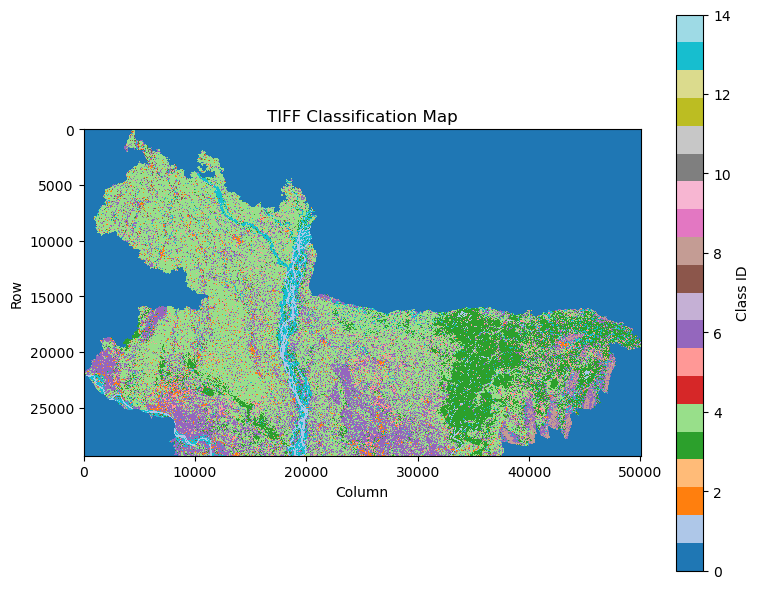

In [4]:
# === 2. Load and read the raster data ===
with rasterio.open("/media/dibakar/DATA/BD_LULC_North/BD_LULC_North.tif") as src:
    data = src.read(1)
    transform = src.transform
    pixel_width = transform[0]
    pixel_height = -transform[4]  # usually negative
    nodata_value = src.nodata  # Safe nodata access

# === 3. Plot the TIFF ===
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='tab20', interpolation='nearest')
plt.colorbar(label="Class ID")
plt.title("TIFF Classification Map")
plt.xlabel("Column")
plt.ylabel("Row")
plt.tight_layout()
plt.show()

In [5]:
print(src.crs)



EPSG:4326


In [6]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS


In [7]:
# === Input and output file paths ===
input_tif = "/media/dibakar/DATA/BD_LULC_North/BD_LULC_North.tif"         # Replace with your input file
output_tif = "BD_LULC_North_reproj.tif" # Output file

# === Define source and target CRS ===
src_crs = CRS.from_epsg(4326)        # WGS 84 (degrees)
dst_crs = CRS.from_epsg(32646)       # UTM Zone 46N (meters)

# === Reprojection ===
with rasterio.open(input_tif) as src:
    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src.width, src.height, *src.bounds
    )

    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(output_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src_crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest  # Use nearest for classified rasters
            )

print("✅ Reprojection complete: EPSG:4326 → EPSG:32646")


✅ Reprojection complete: EPSG:4326 → EPSG:32646



📊 Area per class (from reprojected raster):
  Class 6.0: 163469108 pixels, 1410770.98 ha, 14107.7098 km²
  Class 13.0: 43865793 pixels, 378570.54 ha, 3785.7054 km²
  Class 4.0: 349310965 pixels, 3014623.24 ha, 30146.2324 km²
  Class 5.0: 35686509 pixels, 307981.68 ha, 3079.8168 km²
  Class 2.0: 23004632 pixels, 198534.56 ha, 1985.3456 km²
  Class 3.0: 115187129 pixels, 994087.88 ha, 9940.8788 km²
  Class 7.0: 7682233 pixels, 66299.20 ha, 662.9920 km²
  Class 1.0: 15232150 pixels, 131456.49 ha, 1314.5649 km²
  Class 8.0: 10800261 pixels, 93208.40 ha, 932.0840 km²
  Class 14.0: 226126 pixels, 1951.51 ha, 19.5151 km²


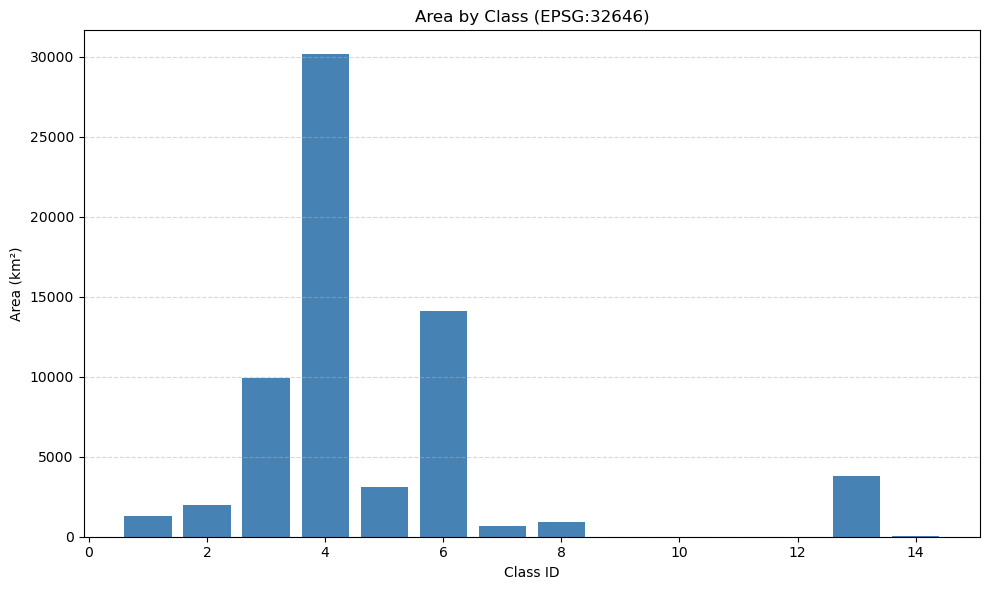

In [8]:
# === Read the reprojected TIFF and calculate area ===
with rasterio.open(output_tif) as src:
    data = src.read(1)  # Read the first band
    transform = src.transform
    nodata = src.nodata

    pixel_area_m2 = abs(transform[0] * transform[4])  # pixel width * height (in m²)

    # Flatten and count pixels per class
    flat = data.flatten()
    if nodata is not None:
        flat = flat[flat != nodata]
    class_counts = Counter(flat)

    # Calculate area in hectares and km²
    results = {}
    for class_id, count in class_counts.items():
        area_m2 = count * pixel_area_m2
        area_ha = area_m2 / 10_000
        area_km2 = area_m2 / 1_000_000
        results[class_id] = {'pixels': count, 'm²': area_m2, 'ha': area_ha, 'km²': area_km2}

# === Print results ===
print("\n📊 Area per class (from reprojected raster):")
for class_id, vals in results.items():
    print(f"  Class {class_id}: {vals['pixels']} pixels, {vals['ha']:.2f} ha, {vals['km²']:.4f} km²")

# === Optional: plot bar chart ===
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [v['km²'] for v in results.values()], color='steelblue')
plt.xlabel("Class ID")
plt.ylabel("Area (km²)")
plt.title("Area by Class (EPSG:32646)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

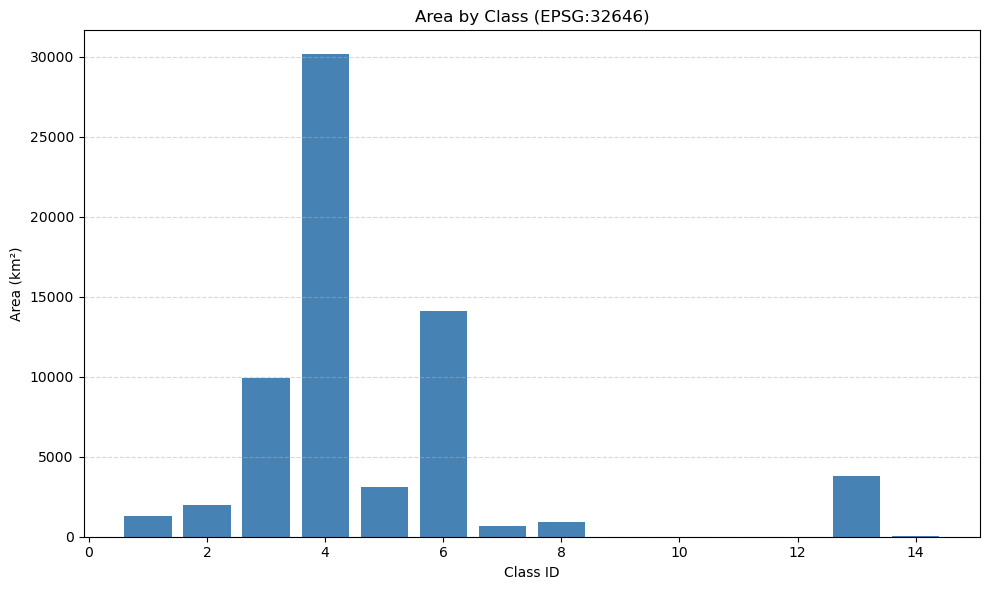

In [9]:
# === Optional: plot bar chart ===
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [v['km²'] for v in results.values()], color='steelblue')
plt.xlabel("Class ID")
plt.ylabel("Area (km²)")
plt.title("Area by Class (EPSG:32646)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# Convert results dict to pandas DataFrame
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'Class ID'
df = df.reset_index()

# Round the area values for neat display
df = df.round({'m²': 2, 'ha': 2, 'km²': 2})

df = df.sort_values(by='Class ID')


# Print as a table
print("\n📋 Class Area Table:\n")
print(df.to_string(index=True))



📋 Class Area Table:

   Class ID     pixels            m²          ha       km²
7       1.0   15232150  1.314565e+09   131456.49   1314.56
4       2.0   23004632  1.985346e+09   198534.56   1985.35
5       3.0  115187129  9.940879e+09   994087.88   9940.88
2       4.0  349310965  3.014623e+10  3014623.24  30146.23
3       5.0   35686509  3.079817e+09   307981.68   3079.82
0       6.0  163469108  1.410771e+10  1410770.98  14107.71
6       7.0    7682233  6.629920e+08    66299.20    662.99
8       8.0   10800261  9.320840e+08    93208.40    932.08
1      13.0   43865793  3.785705e+09   378570.54   3785.71
9      14.0     226126  1.951512e+07     1951.51     19.52
